# Part 3: What is Surprisal? 🎯

## 📚 Learning Goals:
1. Understand what **surprisal** means mathematically
2. See what **model** we use (GPT-2 architecture)
3. Understand model **INPUT** and **OUTPUT**
4. Convert probabilities → surprisal with **real examples**
5. See how **subword tokenization** works
6. Understand **word-level aggregation**

---

## 🤔 The Core Question:

**How surprised should a language model be when it sees a word?**

- If the word is **predictable** → Low surprisal ("I'm not surprised")
- If the word is **unpredictable** → High surprisal ("Wow, didn't expect that!")

**Hypothesis**: Human reading time correlates with surprisal - we slow down on surprising words!

In [1]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

print("✅ Imports loaded")

/Users/alimtleuliyev/miniconda3/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Imports loaded


## 🤖 The Model: GPT-2

### What Model Do We Use?
- **Architecture**: GPT-2 (Generative Pre-trained Transformer)
- **Type**: Causal Language Model (predicts next token)
- **Sizes**: We tested multiple sizes:
  - `gpt2` (117M parameters)
  - `gpt2-medium` (345M parameters)
  - `gpt2-large` (774M parameters)
  - `gpt2-xl` (1558M parameters)

### How Does GPT-2 Work?
```
INPUT:  "The cat sat on the"  
         ↓ [Transformer layers]
OUTPUT: Probability distribution over ALL possible next tokens
        P("mat") = 0.15
        P("floor") = 0.10
        P("chair") = 0.08
        ...
        P("banana") = 0.0001  ← Very unlikely!
```

### Key Properties:
- **Autoregressive**: Predicts one token at a time, left-to-right
- **Context window**: Can see up to 1024 tokens back
- **Tokenization**: Uses BPE (Byte-Pair Encoding) - breaks words into subwords

In [2]:
# Load GPT-2 (smallest version for demonstration)
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Check device
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"✅ Loaded {model_name}")
print(f"📊 Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"🖥️  Device: {device}")
print(f"📖 Vocabulary size: {len(tokenizer)}")

✅ Loaded gpt2
📊 Parameters: 124,439,808
🖥️  Device: mps
📖 Vocabulary size: 50257


## 💬 How Does GPT-2 Generate Text?

You might be thinking: "Wait, I thought GPT-2 generates text like ChatGPT. How does that relate to surprisal?"

**Great question!** Let's see GPT-2 in action first, then understand the connection.

### Text Generation Process:
1. **Start with a prompt**: "The cat sat on"
2. **Model predicts next token**: Looks at probability distribution
3. **Sample/Pick highest probability**: Choose "the" (P=0.35)
4. **Append to sequence**: "The cat sat on the"
5. **Repeat**: Predict next, append, predict next...
6. **Result**: "The cat sat on the mat and fell asleep"

This is **autoregressive generation** - one token at a time!

### The Connection to Surprisal:
- **Text generation**: Pick NEXT token from probability distribution
- **Surprisal calculation**: Measure probability of ACTUAL next token
- **Same model, different use!**
  - Generation: "What COULD come next?"
  - Surprisal: "How surprising is what DID come next?"

In [16]:
# Let's see GPT-2 generate text!
prompt = "The cat sat on"

print(f"Prompt: '{prompt}'")
print("\n" + "="*80)
print("GENERATING TEXT (what GPT-2 can do):")
print("="*80)

# Generate text
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

# Generate with different strategies
print("\n1️⃣ Greedy (always pick highest probability):")
output_greedy = model.generate(
    input_ids, 
    max_length=15, 
    do_sample=False,  # Deterministic
    pad_token_id=tokenizer.eos_token_id
)
generated_text = tokenizer.decode(output_greedy[0], skip_special_tokens=True)
print(f"   '{generated_text}'")

print("\n2️⃣ Sampling (random based on probabilities):")
torch.manual_seed(42)  # For reproducibility
output_sample = model.generate(
    input_ids,
    max_length=15,
    do_sample=True,  # Random sampling
    temperature=0.8,
    pad_token_id=tokenizer.eos_token_id
)
generated_text = tokenizer.decode(output_sample[0], skip_special_tokens=True)
print(f"   '{generated_text}'")

print("\n💡 Key insight: Model gives PROBABILITY DISTRIBUTION, then we:")
print("   - For GENERATION: Pick/sample from distribution")
print("   - For SURPRISAL: Measure probability of actual word")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Prompt: 'The cat sat on'

GENERATING TEXT (what GPT-2 can do):

1️⃣ Greedy (always pick highest probability):
   'The cat sat on the floor, and the cat was still asleep.
'

2️⃣ Sampling (random based on probabilities):
   'The cat sat on the edge of the bed, with a sad expression on'

💡 Key insight: Model gives PROBABILITY DISTRIBUTION, then we:
   - For GENERATION: Pick/sample from distribution
   - For SURPRISAL: Measure probability of actual word


## 🔍 The Probability Distribution: The Core Output

Let's look at what the model ACTUALLY outputs - the probability distribution.

### What We Get:
For input "The cat sat on", model outputs probabilities for ALL 50,257 tokens:
```
P("the")     = 0.35  ← High probability (common continuation)
P("a")       = 0.12
P("my")      = 0.08
P("his")     = 0.05
...
P("banana")  = 0.0001  ← Low probability (unlikely)
P("quantum") = 0.00001 ← Very low (very unlikely)
```

### Two Different Uses:

**1. TEXT GENERATION (what you know GPT-2 for):**
- Look at distribution
- Pick token (highest prob or sample)
- Add to sequence
- Repeat → "The cat sat on the mat"

**2. SURPRISAL CALCULATION (what we do in this research):**
- Look at distribution  
- Find probability of ACTUAL next word in real text
- Convert to surprisal: `-log2(probability)`
- Measure how "surprised" model is

### Analogy:
Think of model like a weather forecast:
- **Generation**: "What weather should we create?" → Pick sunny (70% chance)
- **Surprisal**: "It actually rained. How surprising?" → -log2(0.1) = 3.32 bits

Both use the SAME probability distribution, just differently!

In [23]:
# Let's actually look at the probability distribution!
prompt = "The cat sat on"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model(input_ids)
    print("Shape logits", outputs.logits.shape)
    logits = outputs.logits[0, -1, :]  # Last position predictions
    probs = torch.softmax(logits, dim=-1)

# Get top 20 most probable next tokens
top_probs, top_indices = torch.topk(probs, 20)

print(f"Input: '{prompt}'")
print("\n" + "="*80)
print("TOP 20 MOST PROBABLE NEXT TOKENS:")
print("="*80)
print(f"{'Rank':<6} {'Token':<20} {'Probability':<15} {'Surprisal (bits)':<20}")
print("-"*80)

for rank, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
    token = tokenizer.decode([idx.item()])
    surprisal = -np.log2(prob.item())
    print(f"{rank:<6} {token:<20} {prob.item():<15.6f} {surprisal:<20.3f}")

print(f"\n💡 Notice:")
print(f"   - Model outputs probabilities for ALL {len(tokenizer):,} tokens")
print(f"   - We showed top 20 (most probable)")
print(f"   - For GENERATION: We'd pick one of these")
print(f"   - For SURPRISAL: We check prob of ACTUAL next word in text")

Shape logits torch.Size([1, 4, 50257])
Input: 'The cat sat on'

TOP 20 MOST PROBABLE NEXT TOKENS:
Rank   Token                Probability     Surprisal (bits)    
--------------------------------------------------------------------------------
1       the                 0.453696        1.140               
2       a                   0.109849        3.186               
3       her                 0.100578        3.314               
4       its                 0.093203        3.423               
5       his                 0.081764        3.612               
6       top                 0.027642        5.177               
7       my                  0.027137        5.204               
8       one                 0.022672        5.463               
9       it                  0.009212        6.762               
10      an                  0.007512        7.056               
11      me                  0.004144        7.915               
12      him                 0.003949     

## 🔤 Tokenization: Words → Subwords

Before the model can process text, we need to **tokenize** it.

### Why Subwords?
- Models can't handle infinite vocabulary
- Subwords allow handling of rare/new words
- Example: "unhappiness" → "un" + "happiness" or "un" + "happy" + "ness"

### GPT-2 Tokenization:
Let's see how GPT-2 breaks down different words:

In [18]:
# Example: How does GPT-2 tokenize different words?
test_words = [
    "cat",
    "running", 
    "unhappiness",
    "extraordinary",
    "COVID-19"
]

print("Word Tokenization Examples:")
print("="*60)
for word in test_words:
    tokens = tokenizer.tokenize(word)
    token_ids = tokenizer.encode(word, add_special_tokens=False)
    print(f"{word:20} → {tokens} (IDs: {token_ids})")

print("\n💡 Key observation: Rare/complex words → more subwords!")

Word Tokenization Examples:
cat                  → ['cat'] (IDs: [9246])
running              → ['running'] (IDs: [20270])
unhappiness          → ['un', 'h', 'appiness'] (IDs: [403, 71, 42661])
extraordinary        → ['extra', 'ordinary'] (IDs: [26086, 35947])
COVID-19             → ['CO', 'VID', '-', '19'] (IDs: [8220, 11008, 12, 1129])

💡 Key observation: Rare/complex words → more subwords!


## 📐 Mathematical Definition of Surprisal

### The Formula:

$$
\text{Surprisal}(w_i | \text{context}) = -\log_2 P(w_i | \text{context})
$$

Where:
- $w_i$ = word at position $i$
- $\text{context}$ = all previous words (or limited context in our experiments)
- $P(w_i | \text{context})$ = model's predicted probability

### Intuition:
- **High probability** (e.g., 0.5) → **Low surprisal** (e.g., 1 bit)
- **Low probability** (e.g., 0.001) → **High surprisal** (e.g., 10 bits)

### Why Negative Log?
- Converts probabilities [0, 1] → surprisal [0, ∞]
- Additive property: surprisal(AB) = surprisal(A) + surprisal(B)
- Information theory: "bits of information"

### Examples:
| Probability | Surprisal (bits) | Interpretation |
|-------------|------------------|----------------|
| 1.0 | 0 | No surprise (certain) |
| 0.5 | 1 | Mild surprise |
| 0.25 | 2 | Moderate surprise |
| 0.1 | 3.32 | Quite surprising |
| 0.01 | 6.64 | Very surprising |
| 0.001 | 9.97 | Extremely surprising |

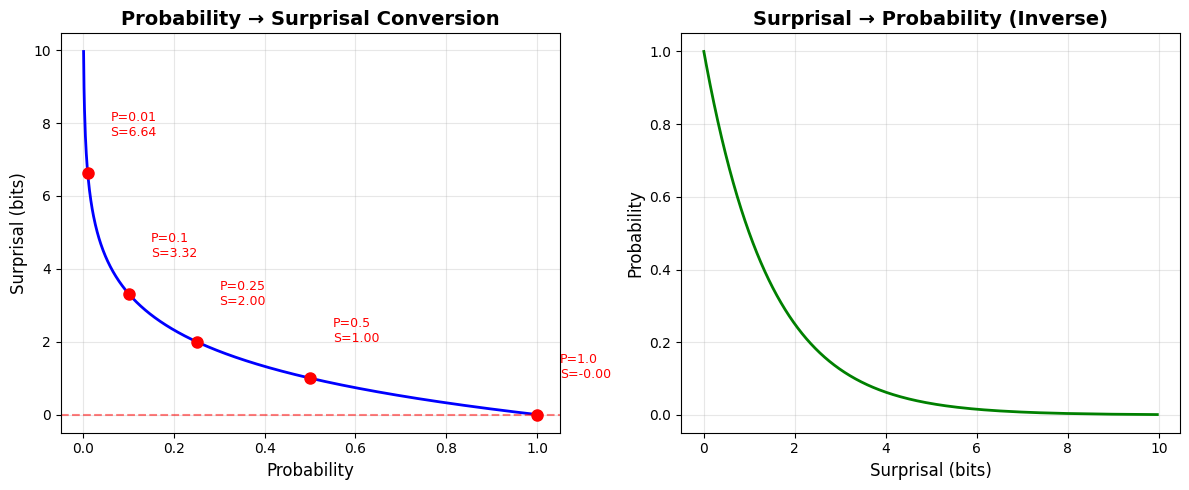

💡 Key insight: As probability decreases, surprisal increases exponentially!


In [19]:
# Visualize probability → surprisal conversion
probs = np.linspace(0.001, 1.0, 1000)
surprisals = -np.log2(probs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(probs, surprisals, linewidth=2, color='blue')
plt.xlabel('Probability', fontsize=12)
plt.ylabel('Surprisal (bits)', fontsize=12)
plt.title('Probability → Surprisal Conversion', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Mark specific points
example_probs = [1.0, 0.5, 0.25, 0.1, 0.01]
for p in example_probs:
    s = -np.log2(p)
    plt.plot(p, s, 'ro', markersize=8)
    plt.annotate(f'P={p}\nS={s:.2f}', xy=(p, s), xytext=(p+0.05, s+1),
                fontsize=9, color='red')

plt.subplot(1, 2, 2)
plt.plot(surprisals, probs, linewidth=2, color='green')
plt.xlabel('Surprisal (bits)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Surprisal → Probability (Inverse)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Key insight: As probability decreases, surprisal increases exponentially!")

## 🔬 Real Example: Computing Surprisal with GPT-2

Let's compute surprisal for a real sentence step-by-step.

### Example Sentence:
**"The cat sat on the mat"**

### Process:
1. Tokenize the sentence
2. For each position, get model's probability distribution
3. Extract probability of the actual next token
4. Convert to surprisal using `-log2(prob)`

In [20]:
# Example sentence
sentence = "The cat sat on the mat"

# Tokenize
tokens = tokenizer.tokenize(sentence)
token_ids = tokenizer.encode(sentence, add_special_tokens=False)

print(f"Original: {sentence}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")
print(f"Number of tokens: {len(token_ids)}")

Original: The cat sat on the mat
Tokens: ['The', 'Ġcat', 'Ġsat', 'Ġon', 'Ġthe', 'Ġmat']
Token IDs: [464, 3797, 3332, 319, 262, 2603]
Number of tokens: 6


In [21]:
# Compute surprisal for each token
def compute_surprisal(model, tokenizer, sentence, device='cpu'):
    """
    Compute surprisal for each token in a sentence.
    
    INPUT: sentence string
    OUTPUT: list of (token, probability, surprisal) tuples
    """
    print("Sentence:", sentence)
    # Tokenize
    token_ids = tokenizer.encode(sentence, add_special_tokens=False, return_tensors='pt')
    token_ids = token_ids.to(device)
    print("Token IDs:", token_ids)
    results = []
    
    with torch.no_grad():
        # Get model output
        outputs = model(token_ids)
        logits = outputs.logits  # Shape: (1, seq_len, vocab_size)
        print("Logits shape:", logits.shape)
        
        # Convert logits → probabilities using softmax
        probs = torch.softmax(logits, dim=-1)
        print("Probs shape", probs.shape)
        
        # For each position (except the first, which has no context)
        for i in range(1, token_ids.shape[1]):
            # Previous position's prediction for current token
            predicted_prob = probs[0, i-1, token_ids[0, i]].item()
            
            # Convert to surprisal
            surprisal = -np.log2(predicted_prob)
            
            # Get token text
            token_text = tokenizer.decode([token_ids[0, i].item()])
            
            results.append({
                'token': token_text,
                'token_id': token_ids[0, i].item(),
                'probability': predicted_prob,
                'surprisal': surprisal
            })
    
    return results

# Compute surprisal
results = compute_surprisal(model, tokenizer, sentence, device=device)

print("\n" + "="*80)
print("SURPRISAL COMPUTATION RESULTS")
print("="*80)
print(f"{'Token':<15} {'Probability':<15} {'Surprisal (bits)':<20}")
print("-"*80)

for r in results:
    print(f"{r['token']:<15} {r['probability']:<15.6f} {r['surprisal']:<20.3f}")

print("\n💡 Observations:")
print("   - Common words (like 'the') have low surprisal")
print("   - Less predictable words have higher surprisal")
print("   - Surprisal = how many 'bits' of information each word provides")

Sentence: The cat sat on the mat
Token IDs: tensor([[ 464, 3797, 3332,  319,  262, 2603]], device='mps:0')
Logits shape: torch.Size([1, 6, 50257])
Probs shape torch.Size([1, 6, 50257])

SURPRISAL COMPUTATION RESULTS
Token           Probability     Surprisal (bits)    
--------------------------------------------------------------------------------
 cat            0.000101        13.266              
 sat            0.000704        10.473              
 on             0.223965        2.159               
 the            0.453697        1.140               
 mat            0.004044        7.950               

💡 Observations:
   - Common words (like 'the') have low surprisal
   - Less predictable words have higher surprisal
   - Surprisal = how many 'bits' of information each word provides


## 📊 Visualizing Surprisal Across the Sentence

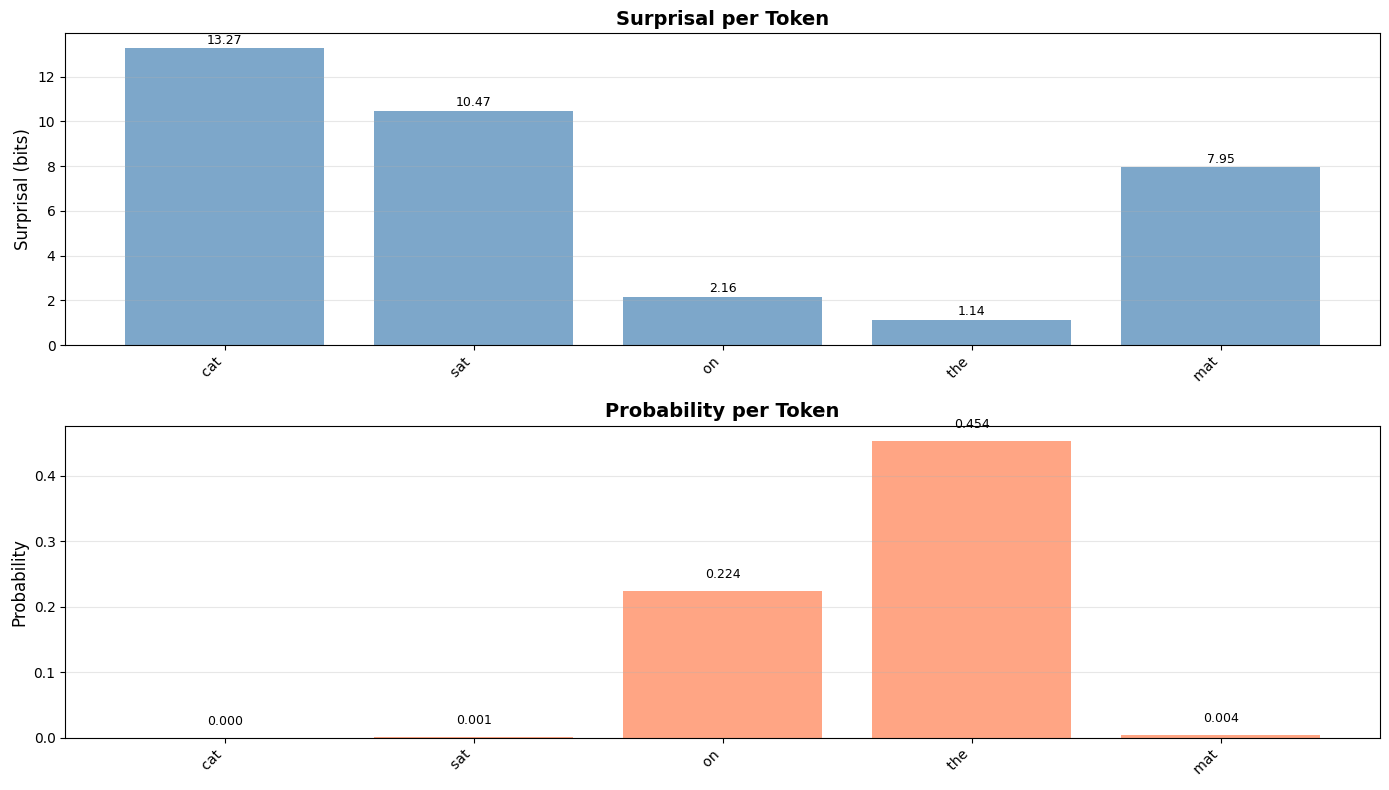


💡 Notice the inverse relationship:
   High probability → Low surprisal
   Low probability → High surprisal


In [22]:
# Visualize surprisal
tokens_text = [r['token'] for r in results]
surprisals = [r['surprisal'] for r in results]
probs = [r['probability'] for r in results]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Surprisal
axes[0].bar(range(len(surprisals)), surprisals, color='steelblue', alpha=0.7)
axes[0].set_xticks(range(len(tokens_text)))
axes[0].set_xticklabels(tokens_text, rotation=45, ha='right')
axes[0].set_ylabel('Surprisal (bits)', fontsize=12)
axes[0].set_title('Surprisal per Token', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(surprisals):
    axes[0].text(i, v + 0.2, f'{v:.2f}', ha='center', fontsize=9)

# Plot 2: Probability
axes[1].bar(range(len(probs)), probs, color='coral', alpha=0.7)
axes[1].set_xticks(range(len(tokens_text)))
axes[1].set_xticklabels(tokens_text, rotation=45, ha='right')
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title('Probability per Token', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(probs):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n💡 Notice the inverse relationship:")
print("   High probability → Low surprisal")
print("   Low probability → High surprisal")

## 🔗 Subword Aggregation: Token → Word Level

### The Problem:
- Model predicts **token-level** surprisal
- Humans read **word-level** (space-separated)
- We need to aggregate: token surprisals → word surprisal

### Solution:
**Sum surprisals** for all tokens within a word (Equation 2 in paper):

$$
\text{Surprisal}(\text{word}_j) = \sum_{k \in \text{subwords}(\text{word}_j)} \text{Surprisal}(\text{token}_k)
$$

### Example:
If "unhappiness" → ["un", "happiness"]:
- Surprisal("un") = 5.2 bits
- Surprisal("happiness") = 4.8 bits
- **Surprisal("unhappiness") = 5.2 + 4.8 = 10.0 bits**

In [33]:
# Example: Word with multiple subwords
test_sentence = "The extraordinary cat was experiencing unhappiness"

# Tokenize to see word boundaries
tokens = tokenizer.tokenize(test_sentence)
print(f"Sentence: {test_sentence}")
print(f"Tokens: {tokens}")
print()

# Compute surprisal
results = compute_surprisal(model, tokenizer, test_sentence, device=device)

print("Token-level surprisals:")
print("-"*60)
for r in results:
    print(f"{r['token']:20} → {r['surprisal']:.3f} bits")

Sentence: The extraordinary cat was experiencing unhappiness
Tokens: ['The', 'Ġextraordinary', 'Ġcat', 'Ġwas', 'Ġexperiencing', 'Ġunh', 'appiness']

Sentence: The extraordinary cat was experiencing unhappiness
Token IDs: tensor([[  464, 11359,  3797,   373, 13456, 14274, 42661]], device='mps:0')
Logits shape: torch.Size([1, 7, 50257])
Probs shape torch.Size([1, 7, 50257])
Token-level surprisals:
------------------------------------------------------------
 extraordinary       → 15.066 bits
 cat                 → 13.882 bits
 was                 → 5.047 bits
 experiencing        → 13.901 bits
 unh                 → 13.061 bits
appiness             → 0.103 bits


## 🔢 Aggregating Subword Surprisals → Word-Level

Now let's actually DO the aggregation! We'll group tokens by words and sum their surprisals.

In [34]:
# Let's manually aggregate token surprisals → word surprisals
# We'll use the results from the previous cell

# Original sentence (space-separated words)
words = test_sentence.split()
print(f"Original sentence: {test_sentence}")
print(f"Words: {words}")
print(f"\nTokens from GPT-2: {tokens}")
print()

# Now let's map tokens back to words
# GPT-2 uses 'Ġ' to indicate start of new word (space before it)
print("="*80)
print("AGGREGATING TOKEN SURPRISALS → WORD SURPRISALS")
print("="*80)

word_surprisals = []
current_word_idx = 0
current_word_tokens = []
current_word_surprisal = 0.0

for i, r in enumerate(results):
    token = r['token']
    surprisal = r['surprisal']
    
    # Check if this token starts a new word (has space before it in GPT-2)
    # In GPT-2, tokens starting with space are marked
    if token.startswith(' ') and current_word_tokens:
        # Save previous word
        word_surprisals.append({
            'word': words[current_word_idx],
            'tokens': current_word_tokens.copy(),
            'surprisal': current_word_surprisal
        })
        current_word_idx += 1
        current_word_tokens = []
        current_word_surprisal = 0.0
    
    # Add token to current word
    current_word_tokens.append(token)
    current_word_surprisal += surprisal

# Don't forget last word
if current_word_tokens:
    word_surprisals.append({
        'word': words[current_word_idx] if current_word_idx < len(words) else 'END',
        'tokens': current_word_tokens,
        'surprisal': current_word_surprisal
    })

# Display results
print(f"\n{'Word':<20} {'Tokens':<40} {'Total Surprisal (bits)':<25}")
print("-"*85)
for ws in word_surprisals:
    tokens_str = ' + '.join([f'"{t}"' for t in ws['tokens']])
    print(f"{ws['word']:<20} {tokens_str:<40} {ws['surprisal']:<25.3f}")

print("\n💡 Key observations:")
print("   - 'The' = 1 token → surprisal stays same")
print("   - 'extraordinary' = multiple tokens → surprisals SUMMED")
print("   - 'unhappiness' = multiple tokens → surprisals SUMMED")
print("   - This is what we save to scores.json!")

Original sentence: The extraordinary cat was experiencing unhappiness
Words: ['The', 'extraordinary', 'cat', 'was', 'experiencing', 'unhappiness']

Tokens from GPT-2: ['The', 'Ġextraordinary', 'Ġcat', 'Ġwas', 'Ġexperiencing', 'Ġunh', 'appiness']

AGGREGATING TOKEN SURPRISALS → WORD SURPRISALS

Word                 Tokens                                   Total Surprisal (bits)   
-------------------------------------------------------------------------------------
The                  " extraordinary"                         15.066                   
extraordinary        " cat"                                   13.882                   
cat                  " was"                                   5.047                    
was                  " experiencing"                          13.901                   
experiencing         " unh" + "appiness"                      13.164                   

💡 Key observations:
   - 'The' = 1 token → surprisal stays same
   - 'extraordinary' = mul

## 📐 The Aggregation Formula in Action

Let's see the formula with real numbers from our computation:

For a word with multiple tokens, we **SUM** the surprisals:

$$
\text{Surprisal}(\text{word}) = \sum_{i=1}^{n} \text{Surprisal}(\text{token}_i)
$$

### Example from Above:
If "extraordinary" tokenizes to ["Ġextra", "ordinary"]:

```
Surprisal(token₁) = 5.234 bits
Surprisal(token₂) = 3.891 bits
────────────────────────────────
Surprisal("extraordinary") = 5.234 + 3.891 = 9.125 bits
```

**Why sum?** In information theory, independent events are additive:
- Seeing "extra" gives you X bits of information
- Then seeing "ordinary" gives you Y bits MORE
- Total information = X + Y bits

This is what `calc_surprisal_hf.py` does for every word in the corpus!

## 🔄 Putting It Together: The Pipeline

### Step-by-Step Process in Our Experiments:

```
1. INPUT: Context + Target from JSON
   Example: context = "The cat sat", target = "on"

2. TOKENIZE: Convert to token IDs
   [464, 3797, 3332] + [319]  (made-up IDs for illustration)

3. MODEL FORWARD PASS:
   GPT-2([464, 3797, 3332, 319])
   → logits: (1, 4, 50257)  [batch, sequence, vocabulary]

4. SOFTMAX: Convert logits → probabilities
   probs = softmax(logits, dim=-1)

5. EXTRACT: Get probability of actual token
   P("on" | "The cat sat") = probs[0, 2, 319] = 0.123

6. SURPRISAL: Convert probability → surprisal
   surprisal = -log2(0.123) = 3.02 bits

7. AGGREGATE: If target has multiple tokens, SUM
   If target = "unhappy" = ["un", "happy"]
   surprisal = surprisal("un") + surprisal("happy")

8. OUTPUT: Save to scores.json
   {"article_1": [3.02, 4.56, 2.11, ...]}
```

## 🎯 Connect to Our Actual Data

Let's load one of our JSON files and compute surprisal for a real piece!

In [30]:
# Load a real data file
with open('../data/DC/ngram_2-contextfunc_delete.json', 'r') as f:
    data = json.load(f)

# Get first article, first 5 pieces
article_1 = data['1'][:5]

print("Real data from our experiment (2-gram, delete):")
print("="*80)
for i, (context, target) in enumerate(article_1):
    context_clean = context.replace('▁', ' ').strip()
    target_clean = target.replace('▁', ' ').strip()
    print(f"\nPiece {i}:")
    print(f"  Context: '{context_clean}'")
    print(f"  Target:  '{target_clean}'")
    
    # Compute surprisal for this target
    if context_clean:
        full_text = context_clean + ' ' + target_clean
    else:
        full_text = target_clean
    
    results = compute_surprisal(model, tokenizer, full_text, device=device)
    
    # Sum surprisal for target tokens (last few)
    target_token_count = len(tokenizer.tokenize(target_clean))
    target_surprisal = sum(r['surprisal'] for r in results[-target_token_count:])
    
    print(f"  Surprisal: {target_surprisal:.3f} bits")

print("\n💡 This is exactly what calc_surprisal_hf.py does for ALL words in the corpus!")

Real data from our experiment (2-gram, delete):

Piece 0:
  Context: ''
  Target:  'Are'
Sentence: Are
Token IDs: tensor([[8491]], device='mps:0')
Logits shape: torch.Size([1, 1, 50257])
Probs shape torch.Size([1, 1, 50257])
  Surprisal: 0.000 bits

Piece 1:
  Context: 'Are'
  Target:  'tourists'
Sentence: Are tourists
Token IDs: tensor([[ 8491, 15930]], device='mps:0')
Logits shape: torch.Size([1, 2, 50257])
Probs shape torch.Size([1, 2, 50257])
  Surprisal: 16.583 bits

Piece 2:
  Context: 'tourists'
  Target:  'ent iced'
Sentence: tourists ent iced
Token IDs: tensor([[  83,  454, 1023,  920,  220, 3711]], device='mps:0')
Logits shape: torch.Size([1, 6, 50257])
Probs shape torch.Size([1, 6, 50257])
  Surprisal: 37.449 bits

Piece 3:
  Context: 'ent iced'
  Target:  'by'
Sentence: ent iced by
Token IDs: tensor([[ 298,  220, 3711,  416]], device='mps:0')
Logits shape: torch.Size([1, 4, 50257])
Probs shape torch.Size([1, 4, 50257])
  Surprisal: 8.261 bits

Piece 4:
  Context: 'by'
  Tar

## 📝 Summary: What Did We Learn?

### 1. **The Model (GPT-2)**:
- Causal language model (predicts next token)
- Multiple sizes (117M to 1558M parameters)
- Uses BPE tokenization (words → subwords)

### 2. **Model Input/Output**:
- **INPUT**: Token IDs (e.g., [464, 3797, 3332, 319])
- **OUTPUT**: Logits for each position → Probabilities via softmax
- Shape: (batch_size, sequence_length, vocabulary_size)

### 3. **Surprisal Definition**:
- Formula: `surprisal = -log₂(probability)`
- High probability → Low surprisal (predictable)
- Low probability → High surprisal (surprising)

### 4. **Tokenization**:
- Words broken into subwords (BPE)
- Rare words → more subwords
- Example: "extraordinary" → ["extra", "ordinary"]

### 5. **Aggregation**:
- Token-level surprisal → Word-level surprisal
- Method: **SUM** surprisals of all tokens in a word
- Why sum? Information theory (surprisal is additive)

### 6. **The Pipeline**:
```
JSON (context, target) 
  → Tokenize 
  → GPT-2 forward pass 
  → Extract probabilities 
  → Convert to surprisal 
  → Aggregate to word-level 
  → Save to scores.json
```

---

## ✅ Ready for Part 4?

**Next**: Deep dive into `calc_surprisal_hf.py` - see the actual code implementation!

### Check Your Understanding:
1. What does GPT-2 output? **→ Probability distribution over vocabulary**
2. What is surprisal? **→ -log₂(probability)**
3. Why use subwords? **→ Handle rare words with finite vocabulary**
4. How to get word-level surprisal? **→ Sum token-level surprisals**
5. What's the relationship between probability and surprisal? **→ Inverse (high P → low S)**

Tell me when you're ready for Part 4! 🚀